Load libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from scipy.stats import ttest_ind
import onnxruntime as ort  # For loading and running the ONNX model

Plug in the ground truth csv and model onnx file, as well as the attributes you'll test for bias and their corresponding subcategories of interest


In [23]:
# Load the CSV data
csv_file = "../data/investigation_train_large_checked.csv"
data = pd.read_csv(csv_file)

# Load the ONNX model
onnx_model_path = "../model_1/good_model3_315.onnx"
session = ort.InferenceSession(onnx_model_path)

# Assume input and output names of the ONNX model are known
# Update these values based on your specific model's input and output names
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

# Prepare input data for the model
# Exclude the target column 'checked' and the columns 'Ja' and 'Nee'
columns_to_exclude = ['checked', 'Ja', 'Nee']
feature_columns = data.columns.difference(columns_to_exclude)
input_data = data[feature_columns].values.astype(np.float32)

# Run predictions
predictions = session.run([output_name], {input_name: input_data})[0]

# Add predictions to the DataFrame
data['model_predictions'] = (predictions > 0.5).astype(int)  # Assuming binary classification

# Define attributes and their corresponding subgroups (numerical ranges or unique values)
attributes = {
    "persoon_leeftijd_bij_onderzoek": [(20, 30), (30, 40), (40, 50), (50, 60), (60, np.inf)],
    "relatie_overig_actueel_vorm__kostendeler": [0, 1, 2, 3, 4, 5],  # Example ranges
    "belemmering_financiele_problemen": [0, 1],  # Binary
    "persoonlijke_eigenschappen_taaleis_voldaan": [0, 1],  # Binary
}

# Use model predictions as the target
target = "model_predictions"

Define the strategy class of all the bias evaluation metrics you'll calculate to assess the model's fairness.

In [24]:
# Strategy pattern for metrics
class BiasMetric:
    def calculate(self, data, attribute, target, subgroups):
        raise NotImplementedError

class StatisticalParityDifference(BiasMetric):
    def calculate(self, data, attribute, target, subgroups):
        rates = []
        for subgroup in subgroups:
            if isinstance(subgroup, tuple):  # Range-based subgroup
                low, high = subgroup
                rate = data[(data[attribute] >= low) & (data[attribute] < high)][target].mean()
            else:  # Single-value subgroup
                rate = data[data[attribute] == subgroup][target].mean()
            rates.append(rate)
        return max(rates) - min(rates)

class DisparateImpactRatio(BiasMetric):
    def calculate(self, data, attribute, target, subgroups):
        rates = []
        for subgroup in subgroups:
            if isinstance(subgroup, tuple):  # Range-based subgroup
                low, high = subgroup
                rate = data[(data[attribute] >= low) & (data[attribute] < high)][target].mean()
            else:  # Single-value subgroup
                rate = data[data[attribute] == subgroup][target].mean()
            rates.append(rate)
        return min(rates) / max(rates) if max(rates) > 0 else 0

# class TTestMetric(BiasMetric):
#     def calculate(self, data, attribute, target, subgroups):
#         group_data = []
#         for subgroup in subgroups:
#             if isinstance(subgroup, tuple):  # Range-based subgroup
#                 low, high = subgroup
#                 group = data[(data[attribute] >= low) & (data[attribute] < high)][target]
#             else:  # Single-value subgroup
#                 group = data[data[attribute] == subgroup][target]
#             group_data.append(group)
#         if len(group_data) >= 2:  # Ensure at least two groups for t-test
#             t_stat, p_val = ttest_ind(group_data[0], group_data[1], equal_var=False)
#             return p_val
#         else:
#             return np.nan  # Return NaN if fewer than two groups

class WeightedBiasMetric(BiasMetric):
    def calculate(self, data, attribute, target, subgroups):
        """
        Calculates the weighted bias score for underrepresented subgroups with higher chances of being positive.
        
        :param data: DataFrame containing the data
        :param attribute: The attribute to group by
        :param target: The target variable (boolean, 0 or 1)
        :param subgroups: A list of subgroups to compare. Can be values or ranges (tuples)
        :return: Bias score indicating the weighted bias
        """
        # Calculate the overall proportion of positive outcomes
        total_positive = data[target].sum()
        total_samples = len(data)
        total_proportion = total_positive / total_samples
        
        # Initialize list to store subgroup proportions and weights
        subgroup_proportions = []
        subgroup_weights = []
        
        # Loop through the subgroups to calculate their proportions and weights
        for subgroup in subgroups:
            if isinstance(subgroup, tuple):  # Range-based subgroup
                low, high = subgroup
                group_data = data[(data[attribute] >= low) & (data[attribute] < high)]
            else:  # Single-value subgroup
                group_data = data[data[attribute] == subgroup]
            
            # Proportion of positive outcomes in the current subgroup
            subgroup_positive = group_data[target].sum()
            subgroup_size = len(group_data)
            subgroup_proportion = subgroup_positive / subgroup_size if subgroup_size > 0 else 0
            
            # Weight of the subgroup (proportion of total samples)
            subgroup_weight = subgroup_size / total_samples
            
            # Append to the lists
            subgroup_proportions.append(subgroup_proportion)
            subgroup_weights.append(subgroup_weight)
        
        # Calculate the weighted bias score
        bias_score = round(sum(w * abs(p - total_proportion) for p, w in zip(subgroup_proportions, subgroup_weights)), 6)
        
        return bias_score

Define which metrics you'll use from the suite.

In [25]:
# Instantiate metrics
metrics = {
    "Statistical Parity Difference": StatisticalParityDifference(),
    "Disparate Impact Ratio": DisparateImpactRatio(),
    "Weighted Bias Score": WeightedBiasMetric(),
    # "T-Test": TTestMetric(),
}

Evaluate your model's fairness and biases.

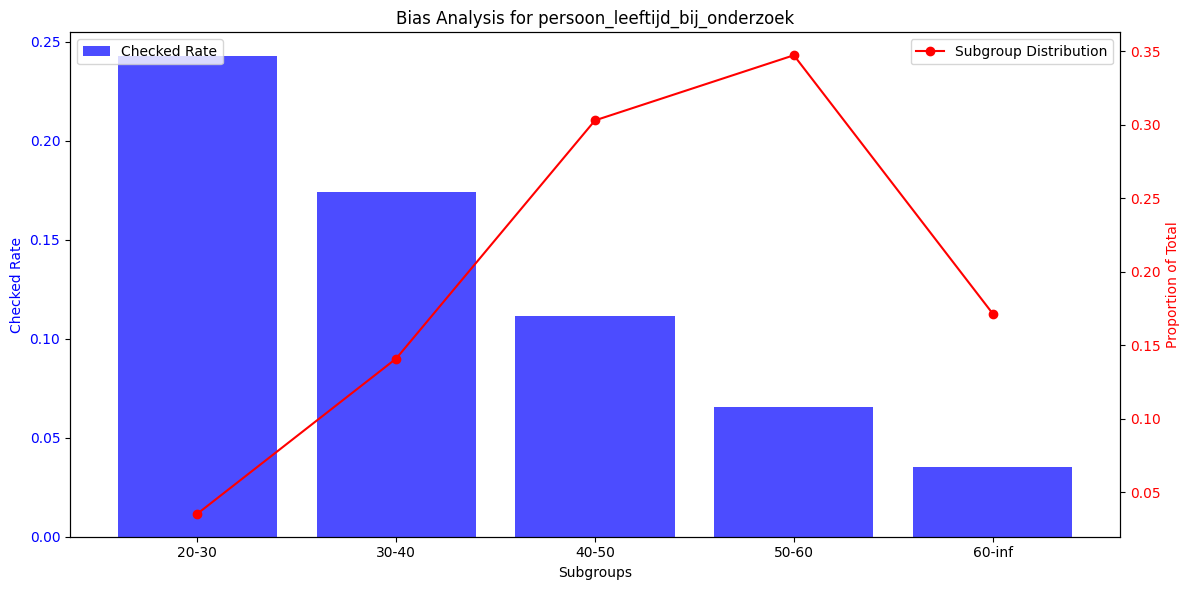

Metrics for persoon_leeftijd_bij_onderzoek:
Statistical Parity Difference: 0.20757488243832617
Disparate Impact Ratio: 0.14428692342448743
Weighted Bias Score: 0.04194


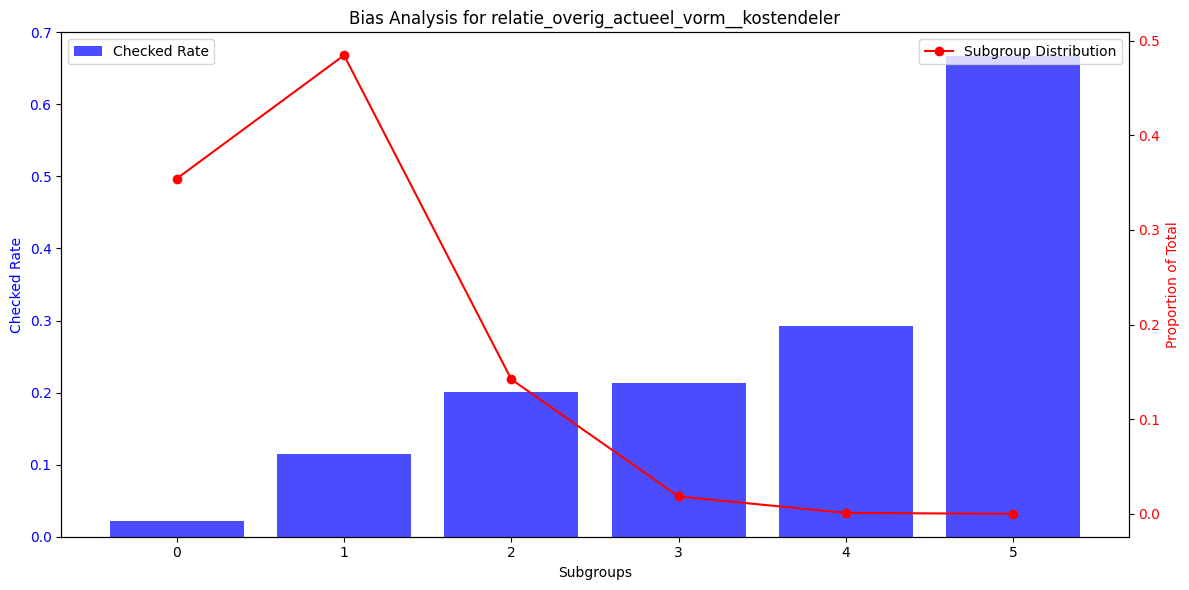

Metrics for relatie_overig_actueel_vorm__kostendeler:
Statistical Parity Difference: 0.6450125247962005
Disparate Impact Ratio: 0.03248121280569915
Weighted Bias Score: 0.052842


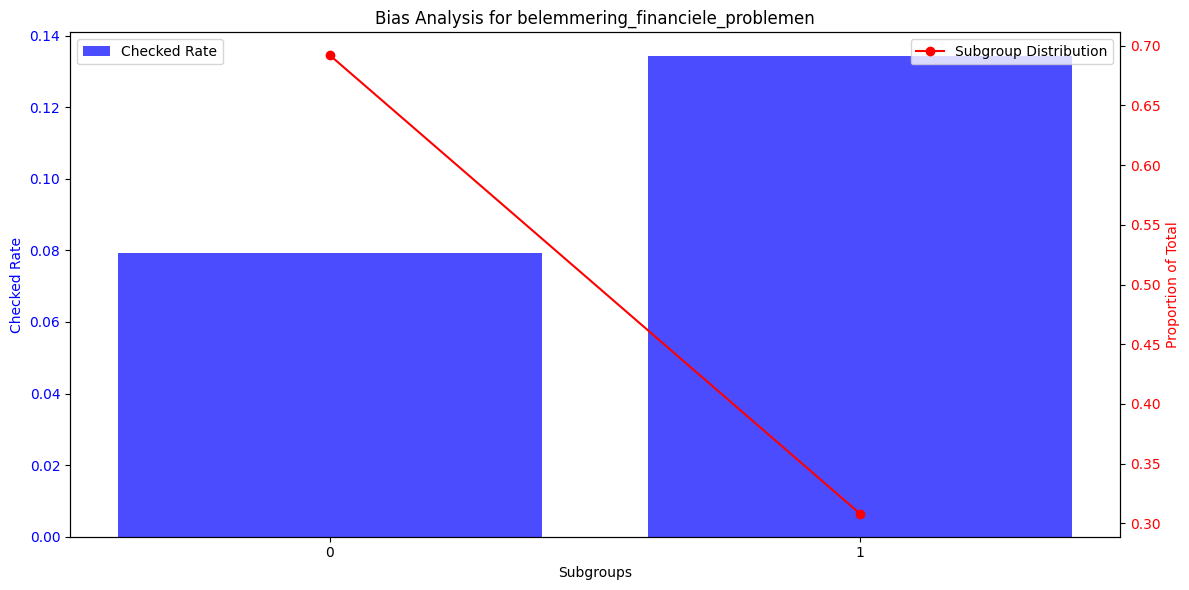

Metrics for belemmering_financiele_problemen:
Statistical Parity Difference: 0.054879662575530896
Disparate Impact Ratio: 0.5911383471958401
Weighted Bias Score: 0.023398


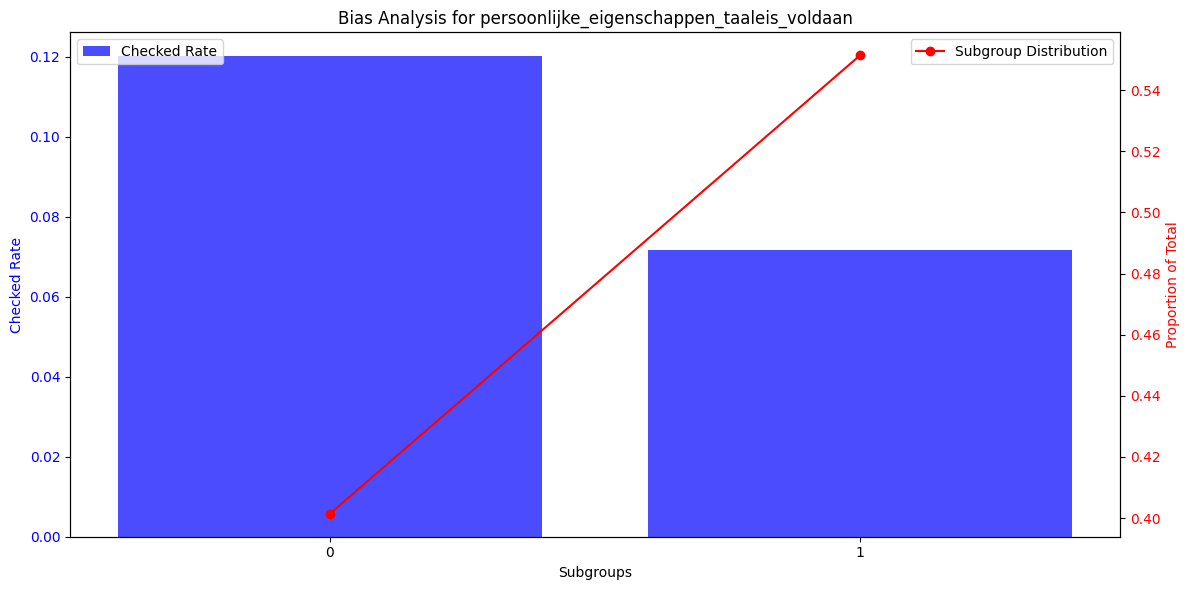

Metrics for persoonlijke_eigenschappen_taaleis_voldaan:
Statistical Parity Difference: 0.04830421330063715
Disparate Impact Ratio: 0.5976447931215084
Weighted Bias Score: 0.023065


In [26]:
# Evaluate and plot
for attribute, subgroups in attributes.items():
    results = {}
    for metric_name, metric in metrics.items():
        results[metric_name] = metric.calculate(data, attribute, target, subgroups)

    # Prepare data for visualization
    subgroup_labels = []
    checked_means = []
    subgroup_sizes = []

    for subgroup in subgroups:
        if isinstance(subgroup, tuple):  # Numerical range
            low, high = subgroup
            subset = data[(data[attribute] >= low) & (data[attribute] < high)]
            label = f"{low}-{high}"
        else:  # Single value
            subset = data[data[attribute] == subgroup]
            label = str(subgroup)

        subgroup_labels.append(label)
        checked_means.append(subset[target].mean())
        subgroup_sizes.append(len(subset) / len(data))  # Proportion of total data

    # Create dual-axis plot
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Bar plot for checked rates
    ax1.bar(subgroup_labels, checked_means, color='b', alpha=0.7, label='Checked Rate')
    ax1.set_ylabel("Checked Rate", color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    # Line plot for subgroup distribution
    ax2 = ax1.twinx()
    ax2.plot(subgroup_labels, subgroup_sizes, color='r', marker='o', linestyle='-', label='Subgroup Distribution')
    ax2.set_ylabel("Proportion of Total", color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    # Add titles and legends
    plt.title(f"Bias Analysis for {attribute}")
    ax1.set_xlabel("Subgroups")
    fig.tight_layout()
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")

    plt.show()

    # Print metric results
    print(f"Metrics for {attribute}:")
    for metric_name, value in results.items():
        print(f"{metric_name}: {value}")

